### Imports

In [3]:
#from backtesting.test import EURUSD, GOOG

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
PERIOD = 24

### Process parquet

In [5]:
import pandas as pd
import pyarrow.parquet as pq

DATA_PATH='/home/bkadmin/datasets/spatialedge-hackathon-H1/v1/' 
FROM_DATE='20171001'
TO_DATE='20200101'
SYMBOL = 'EURUSD'
TIMEFRAME = 'H1'

def read_and_process_parquet(data_path, from_date, to_date, symbol, timeframe):
    partition = ['symbol','timeframe', 'date', 'date']
    operator = ['=', '=', '>=', '<=']
    params = [symbol, timeframe, from_date, to_date]
            
    dataset = pq.ParquetDataset(data_path, filters=list(zip(partition, operator, params)), use_legacy_dataset=True)
    table = dataset.read()
    df = table.to_pandas()

    df['date'] = df['date'].astype(str)
    df['time'] = df['time'].astype(str)

    df['datetime'] = df['date'] + ' ' + df['time']
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y%m%d %H:%M:%S')
    df.set_index('datetime', inplace=True)

    df.drop(['time', 'symbol', 'timeframe', 'date'], axis=1, inplace=True)
    df = df.sort_values('datetime')
    df.fillna(method='ffill', inplace=True)

    return df 

data = read_and_process_parquet(DATA_PATH, FROM_DATE, TO_DATE, SYMBOL, TIMEFRAME)

/tmp/ipykernel_180527/466083291.py:15: FutureWarning: Passing 'use_legacy_dataset=True' to get the legacy behaviour is deprecated as of pyarrow 11.0.0, and the legacy implementation will be removed in a future version.
  dataset = pq.ParquetDataset(data_path, filters=list(zip(partition, operator, params)), use_legacy_dataset=True)
/tmp/ipykernel_180527/466083291.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


### Create helper functions

In [6]:
# Relative Strength Index (RSI)
def RSI(values, period=168):
    delta = pd.Series(values).diff()
    gain = delta.where(delta>0.0)
    #gain.fillna(0, inplace=True) 
    loss = -delta.where(delta<0.0)
    #loss.fillna(0, inplace=True) 
    # #TODO: instead of replacing with 0, remove those vaues
    avg_gain = gain.rolling(period, min_periods=1).mean() # average gain over 7 day period (168hr) 
    avg_gain.fillna(0, inplace=True)
    avg_loss = loss.rolling(period, min_periods=1).mean() # average loss over 7 day period (168hr)
    avg_loss.fillna(0.000000001, inplace=True)
    rs = (avg_gain/avg_loss)
    rsi = 100-(100/(1+rs))

    return rsi



def Stochastic_Oscillator(values, period=168):
    '''Calculates stochastic oscillator'''
    time_period = period
    data = pd.Series(values)
    if len(values) < time_period:
        time_period = len(values)
    lowest_close_in_period = data.rolling(time_period, min_periods=1).min()
    highest_close_in_period = data.rolling(time_period, min_periods=1).max()
    so = ((data-lowest_close_in_period)/(highest_close_in_period-lowest_close_in_period))*100
    return so


def BBANDS(data, n_lookback, n_std):
    """Bollinger bands indicator"""
    hlc3 = (data.High + data.Low + data.Close) / 3
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()
    upper = mean + n_std*std
    lower = mean - n_std*std
    return upper, lower


### Create features

In [7]:
from feature_engine.timeseries.forecasting import LagFeatures
import numpy as np
import pandas_ta as ta

# Simple Moving Average
def SMA(values, n):
    return pd.Series(values).rolling(n).mean()

day = 24
month = 30 * day
year = (365.2425) * day

data.columns = ['Open','High','Low','Close','Volume']
open, low, high, close = data.Open, data.Low, data.High, data.Close 

data['X_RSI'] = ta.rsi(close, PERIOD * 14)
# data.ta.stoch(high='High', low='Low', close='Close', k=PERIOD * 14, d=PERIOD * 3, append=True) 

data['X_SMA1']  = SMA(close, PERIOD)
data['X_SMA14'] = SMA(close, PERIOD * 14)
data['X_SMA28'] = SMA(close, PERIOD * 28)
data['X_SMA56'] = SMA(close, PERIOD * 56)

# Time indicators
data['X_day'] = data.index.dayofweek
data['X_hour'] = data.index.hour

data['X_Day_Sin'] = np.sin(data.index.hour * (2 * np.pi / day))
data['X_Day_Cos'] = np.cos(data.index.hour * (2 * np.pi / day))
data['X_Day_Tan'] = np.tan(data.index.hour * (2 * np.pi / day))

data['X_Day_Sin'] = np.sin(data.index.day * (2 * np.pi / month))
data['X_Day_Cos'] = np.cos(data.index.day * (2 * np.pi / month))
data['X_Day_Tan'] = np.tan(data.index.day * (2 * np.pi / month))

data['X_Year_Sin'] = np.sin(data.index.dayofyear * (2 * np.pi / year))
data['X_Year_Cos'] = np.cos(data.index.dayofyear * (2 * np.pi / year))
data['X_Year_Tan'] = np.tan(data.index.dayofyear * (2 * np.pi / year))

data['X_MOM'] = data.Close.pct_change(periods=PERIOD * 2)
data['X_BB_UP'] = SMA(close, PERIOD * 14) + (2 * ta.stdev(close, PERIOD * 14))
data['X_BB_LOW'] = SMA(close, PERIOD * 14) - (2 * ta.stdev(close, PERIOD * 14))

data

,Open,High,Low,Close,Volume,X_RSI,X_SMA1,X_SMA14,X_SMA28,X_SMA56,...,X_hour,X_Day_Sin,X_Day_Cos,X_Day_Tan,X_Year_Sin,X_Year_Cos,X_Year_Tan,X_MOM,X_BB_UP,X_BB_LOW
datetime,,,,,,,,,,,,,,,,,,,,,
2017-10-01 21:00:00,1.179150,1.180890,1.179150,1.180710,3164.950023,NaN,NaN,NaN,NaN,NaN,...,21,0.008727,0.999962,0.008727,0.195138,0.980776,0.198963,NaN,NaN,NaN
2017-10-01 22:00:00,1.180710,1.181535,1.180340,1.181110,6752.000007,NaN,NaN,NaN,NaN,NaN,...,22,0.008727,0.999962,0.008727,0.195138,0.980776,0.198963,NaN,NaN,NaN
2017-10-01 23:00:00,1.181115,1.181145,1.180605,1.180815,6845.029987,NaN,NaN,NaN,NaN,NaN,...,23,0.008727,0.999962,0.008727,0.195138,0.980776,0.198963,NaN,NaN,NaN
2017-10-02 00:00:00,1.180810,1.180810,1.178785,1.178940,13671.169988,NaN,NaN,NaN,NaN,NaN,...,0,0.017452,0.999848,0.017455,0.195841,0.980636,0.199708,NaN,NaN,NaN
2017-10-02 01:00:00,1.178970,1.179130,1.177060,1.177430,20139.609951,NaN,NaN,NaN,NaN,NaN,...,1,0.017452,0.999848,0.017455,0.195841,0.980636,0.199708,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 12:00:00,1.122785,1.123300,1.122715,1.123075,12510.530008,54.886324,1.120782,1.112786,1.108903,1.108708,...,12,0.267238,0.963630,0.277325,0.258651,0.965971,0.267763,0.006985,1.120542,1.105031
2019-12-31 13:00:00,1.123080,1.123900,1.122905,1.123805,14306.150008,55.138872,1.120961,1.112832,1.108928,1.108724,...,13,0.267238,0.963630,0.277325,0.258651,0.965971,0.267763,0.007581,1.120666,1.104997
2019-12-31 14:00:00,1.123830,1.123920,1.121815,1.122080,18918.570006,54.416884,1.121023,1.112870,1.108948,1.108738,...,14,0.267238,0.963630,0.277325,0.258651,0.965971,0.267763,0.005619,1.120758,1.104982


In [8]:
# Lagging price indicator
#data['X_LAG1'] = data.Close.shift(24)
lf = LagFeatures(periods=PERIOD, variables = ["Close"])
data.index.value_counts()

datetime
2019-03-11 00:00:00    2
2018-03-12 00:00:00    2
2019-04-02 10:00:00    1
2019-04-01 23:00:00    1
2019-04-02 00:00:00    1
                      ..
2018-07-02 14:00:00    1
2018-07-02 15:00:00    1
2018-07-02 16:00:00    1
2018-07-02 17:00:00    1
2020-01-01 23:00:00    1
Name: count, Length: 14002, dtype: int64

In [9]:
data = data[~data.index.duplicated(keep='first')]
data.index.value_counts()

datetime
2017-10-01 21:00:00    1
2019-04-02 08:00:00    1
2019-04-01 21:00:00    1
2019-04-01 22:00:00    1
2019-04-01 23:00:00    1
                      ..
2018-07-02 13:00:00    1
2018-07-02 14:00:00    1
2018-07-02 15:00:00    1
2018-07-02 16:00:00    1
2020-01-01 23:00:00    1
Name: count, Length: 14002, dtype: int64

In [10]:
data = lf.fit_transform(data)
data = data.dropna()
data.dropna().astype(float)

,Open,High,Low,Close,Volume,X_RSI,X_SMA1,X_SMA14,X_SMA28,X_SMA56,...,X_Day_Sin,X_Day_Cos,X_Day_Tan,X_Year_Sin,X_Year_Cos,X_Year_Tan,X_MOM,X_BB_UP,X_BB_LOW,Close_lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2017-12-18 21:00:00,1.178110,1.178380,1.177900,1.178155,9894.200019,49.855494,1.177903,1.181233,1.179204,1.175988,...,0.156434,0.987688,0.158384,0.249639,0.968339,0.257801,0.000318,1.190876,1.171590,1.175055
2017-12-18 22:00:00,1.178160,1.178655,1.178090,1.178295,7851.150056,49.886959,1.178055,1.181214,1.179233,1.175986,...,0.156434,0.987688,0.158384,0.249639,0.968339,0.257801,0.001487,1.190855,1.171573,1.174650
2017-12-18 23:00:00,1.178290,1.178505,1.178195,1.178395,7513.509996,49.909477,1.178224,1.181194,1.179261,1.175984,...,0.156434,0.987688,0.158384,0.249639,0.968339,0.257801,0.000794,1.190831,1.171557,1.174335
2017-12-19 00:00:00,1.178390,1.178460,1.177745,1.178325,10214.480029,49.893737,1.178364,1.181175,1.179290,1.175982,...,0.165048,0.986286,0.167343,0.250333,0.968160,0.258566,-0.000208,1.190809,1.171541,1.174975
2017-12-19 01:00:00,1.178315,1.178410,1.177660,1.178235,9124.830019,49.873453,1.178471,1.181157,1.179318,1.175982,...,0.165048,0.986286,0.167343,0.250333,0.968160,0.258566,-0.000195,1.190791,1.171524,1.175655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 12:00:00,1.122785,1.123300,1.122715,1.123075,12510.530008,54.886324,1.120782,1.112786,1.108903,1.108708,...,0.267238,0.963630,0.277325,0.258651,0.965971,0.267763,0.006985,1.120542,1.105031,1.118975
2019-12-31 13:00:00,1.123080,1.123900,1.122905,1.123805,14306.150008,55.138872,1.120961,1.112832,1.108928,1.108724,...,0.267238,0.963630,0.277325,0.258651,0.965971,0.267763,0.007581,1.120666,1.104997,1.119490
2019-12-31 14:00:00,1.123830,1.123920,1.121815,1.122080,18918.570006,54.416884,1.121023,1.112870,1.108948,1.108738,...,0.267238,0.963630,0.277325,0.258651,0.965971,0.267763,0.005619,1.120758,1.104982,1.120605


# Feature Importance

### Create matrix

In [26]:
def get_X(data):
    return data.filter(like='X').values

def get_y(data):
    y = data.Close.pct_change(PERIOD).shift(-PERIOD)
    y[y.between(-.005,.005)] = 0
    y[y > 0] = 1
    y[y < 0] = -1
    return y

def get_clean_Xy(df):
    X = get_X(df)
    y = get_y(df).values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    return X, y

### Test model

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, log_loss
from sklearn.model_selection import train_test_split

X, y = get_clean_Xy(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=0)

# Assuming y_train and X_train are both numpy arrays
data2 = np.column_stack((y_train, X_train))

# Xtrain
data2 = pd.Series(y_train) + pd.DataFrame(X_train) 

from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(penalty='l2', C=1.0)
model_lr.fit(X_train, y_train)

/home/bkadmin/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [28]:
column_names = tuple(data.columns[5:])

feature_importance = model_lr.coef_

feature_importance = np.abs(feature_importance)
feature_ranking = np.argsort(feature_importance)[0][::-1]

# Create a dictionary to store feature importances with their corresponding column names
feature_importance_dict = {column_name: importance for column_name, importance in zip(column_names, feature_importance[0])}
feature_importance_dict


{'X_RSI': 0.020854530098703285,
 'X_SMA1': 0.47542094680557395,
 'X_SMA14': 0.3195031482358823,
 'X_SMA28': 0.3229332887396201,
 'X_SMA56': 0.284976986889512,
 'X_day': 0.02377944063207403,
 'X_hour': 0.005708190080554358,
 'X_Day_Sin': 0.558110628427351,
 'X_Day_Cos': 0.7754918172537723,
 'X_Day_Tan': 0.5838246721158172,
 'X_Year_Sin': 0.5360711431098233,
 'X_Year_Cos': 0.6072284779035988,
 'X_Year_Tan': 0.5570270314569377,
 'X_MOM': 0.06271436650880022,
 'X_BB_UP': 0.3749164085855545,
 'X_BB_LOW': 0.2640898878862533}

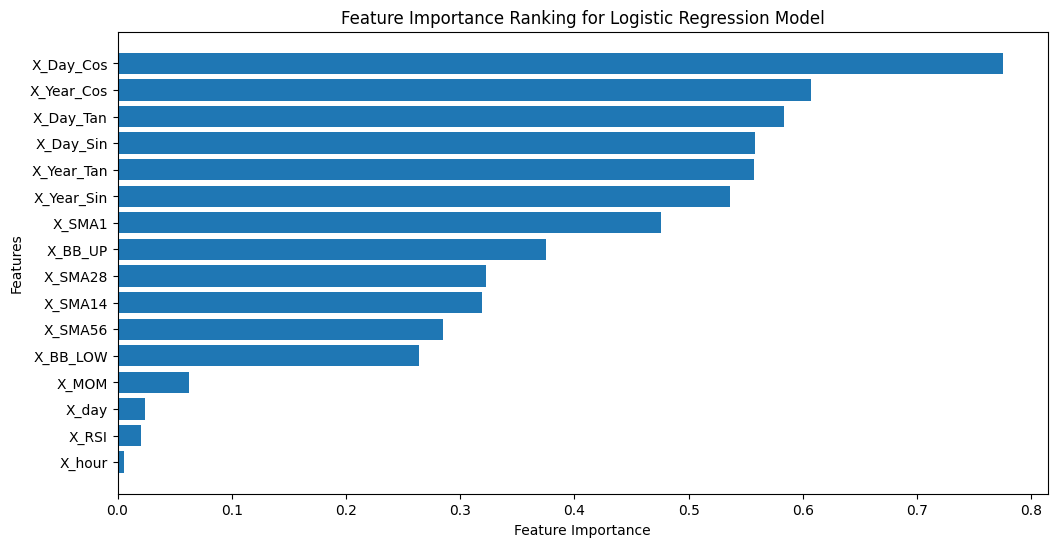

In [29]:
import matplotlib.pyplot as plt

# Sort feature importances in descending order
sorted_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Extract the sorted feature names and importance scores
sorted_feature_names = [item[0] for item in sorted_importance]
sorted_importance_scores = [item[1] for item in sorted_importance]

# Create a bar plot to visualize the sorted feature importances
plt.figure(figsize=(12, 6))
plt.barh(sorted_feature_names, sorted_importance_scores)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Ranking for Logistic Regression Model')
plt.gca().invert_yaxis()
plt.show()



In [30]:
new_data = data.drop(sorted_feature_names[11:], axis='columns')

new_data

,Open,High,Low,Close,Volume,X_SMA1,X_SMA14,X_SMA28,X_SMA56,X_Day_Sin,X_Day_Cos,X_Day_Tan,X_Year_Sin,X_Year_Cos,X_Year_Tan,X_BB_UP,Close_lag_24
datetime,,,,,,,,,,,,,,,,,
2017-12-18 21:00:00,1.178110,1.178380,1.177900,1.178155,9894.200019,1.177903,1.181233,1.179204,1.175988,0.156434,0.987688,0.158384,0.249639,0.968339,0.257801,1.190876,1.175055
2017-12-18 22:00:00,1.178160,1.178655,1.178090,1.178295,7851.150056,1.178055,1.181214,1.179233,1.175986,0.156434,0.987688,0.158384,0.249639,0.968339,0.257801,1.190855,1.174650
2017-12-18 23:00:00,1.178290,1.178505,1.178195,1.178395,7513.509996,1.178224,1.181194,1.179261,1.175984,0.156434,0.987688,0.158384,0.249639,0.968339,0.257801,1.190831,1.174335
2017-12-19 00:00:00,1.178390,1.178460,1.177745,1.178325,10214.480029,1.178364,1.181175,1.179290,1.175982,0.165048,0.986286,0.167343,0.250333,0.968160,0.258566,1.190809,1.174975
2017-12-19 01:00:00,1.178315,1.178410,1.177660,1.178235,9124.830019,1.178471,1.181157,1.179318,1.175982,0.165048,0.986286,0.167343,0.250333,0.968160,0.258566,1.190791,1.175655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 12:00:00,1.122785,1.123300,1.122715,1.123075,12510.530008,1.120782,1.112786,1.108903,1.108708,0.267238,0.963630,0.277325,0.258651,0.965971,0.267763,1.120542,1.118975
2019-12-31 13:00:00,1.123080,1.123900,1.122905,1.123805,14306.150008,1.120961,1.112832,1.108928,1.108724,0.267238,0.963630,0.277325,0.258651,0.965971,0.267763,1.120666,1.119490
2019-12-31 14:00:00,1.123830,1.123920,1.121815,1.122080,18918.570006,1.121023,1.112870,1.108948,1.108738,0.267238,0.963630,0.277325,0.258651,0.965971,0.267763,1.120758,1.120605


In [16]:
#del X, y, X_train, X_test, y_train, y_test

#X, y = get_clean_Xy(new_data)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=0)

#model = DecisionTreeClassifier()

#model.fit(X_train,y_train)

#y_pred = model.predict(X_test)

#print('Classification accuracy: ', np.mean(y_test == y_pred))

#print(classification_report(y_test, y_pred))

#_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)


Classification accuracy:  0.9323308270676691
              precision    recall  f1-score   support

        -1.0       0.87      0.75      0.81       242
         0.0       0.94      0.98      0.96      2051
         1.0       0.92      0.71      0.80       234

    accuracy                           0.93      2527
   macro avg       0.91      0.81      0.85      2527
weighted avg       0.93      0.93      0.93      2527



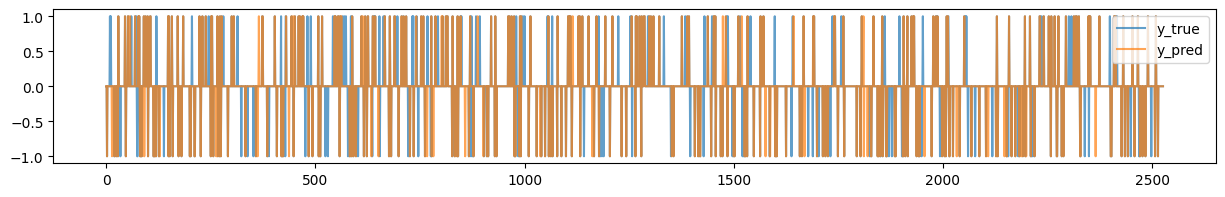

In [31]:
clf = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

clf.fit(X_train, y_train_encoded)

y_pred = clf.predict(X_test) - 1

print('Classification accuracy: ', np.mean(y_test == y_pred))
print(classification_report(y_test, y_pred))
_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)


### Strategy based on Relative Strength Index

In [57]:
from backtesting import Strategy, Backtest
from backtesting.lib import crossover

CASH = 100_000        
COMMISSION=0.001

N_TRAIN = 24 * 481

class MLStrategy(Strategy):    
    price_delta = .009
    
    def init(self):
        #self.clf = DecisionTreeClassifier()
        
        self.clf = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

        df = self.data.df.iloc[:N_TRAIN]
        X,y = get_clean_Xy(df)

        #self.clf.fit(X,y)

        le = LabelEncoder()
        y_train_encoded = le.fit_transform(y)
        self.clf.fit(X, y_train_encoded)

        self.tradecount = 0
        self.maxdaytrades = 4

        self.tpo = False
        self.I(get_y, self.data.df, name='y_true')

        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name = 'forecast')

    def next(self):
        if len(self.data) < N_TRAIN: return

        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]

        if current_time.hour == 0:
            self.tradecount = 0
        
        forecast = self.clf.predict(get_X(self.data.df.iloc[-1:])) 

        self.forecasts[-1] = forecast - 1
        
        upper, lower = close[-1] * (1 + np.r_[1, -1] * self.price_delta)

        if forecast == 1 and not self.position.is_long and self.tradecount <= self.maxdaytrades:
            self.buy(size=.3, tp=upper, sl=lower)
            self.tradecount += 1
        elif forecast == -1 and not self.position.is_short and self.tradecount <= self.maxdaytrades:
            self.sell(size=.3, tp=lower, sl=upper)
            self.tradecount += 1

        # Additionally, set aggressive stop-loss on trades that have been open 
        # for more than two days
        #for trade in self.trades:
        #    if current_time - trade.entry_time > pd.Timedelta('12 days'):
        #        if trade.is_long:
        #            trade.sl = max(trade.sl, low)
        #        else:
        #            trade.sl = min(trade.sl, high)

        if self.equity > CASH*1.1: # If equity i500 ever 10% higher than starting cash, close position and cease trading
           self.position.close()
            #self.tpo=True        

### Backtest

In [58]:
bt = Backtest(new_data, MLStrategy, cash=CASH, commission=COMMISSION)
stats = bt.run()
stats

Start                     2017-12-18 21:00:00
End                       2020-01-01 23:00:00
Duration                    744 days 02:00:00
Exposure Time [%]                    8.807963
Equity Final [$]                100074.422959
Equity Peak [$]                 100219.213816
Return [%]                           0.074423
Buy & Hold Return [%]               -4.775263
Return (Ann.) [%]                    0.029435
Volatility (Ann.) [%]                0.320148
Sharpe Ratio                         0.091943
Sortino Ratio                        0.122743
Calmar Ratio                          0.05315
Max. Drawdown [%]                   -0.553822
Avg. Drawdown [%]                   -0.077877
Max. Drawdown Duration       62 days 15:00:00
Avg. Drawdown Duration        6 days 13:00:00
# Trades                                    7
Win Rate [%]                        57.142857
Best Trade [%]                       0.799657
Worst Trade [%]                     -0.995017
Avg. Trade [%]                    

In [93]:
bt.plot()

/home/bkadmin/.local/lib/python3.11/site-packages/backtesting/_plotting.py:122: UserWarning: Data contains too many candlesticks to plot; downsampling to '2H'. See `Backtest.plot(resample=...)`
  warnings.warn(f"Data contains too many candlesticks to plot; downsampling to {freq!r}. "


TypeError: Index.get_loc() got an unexpected keyword argument 'method'